**Importing Nesseccary Libraries**

In [1]:
import numpy as np
from numpy import linalg as LA
import pandas as pd
import random
import itertools

import matplotlib.pyplot as plt
import matplotlib
from tabulate import tabulate

from google.colab import drive

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score as f1Score
from sklearn import preprocessing

random.seed(42)

Part A:

Gaussian Naive Bayesian

In [2]:
class myGNB():
  def __init__(self, _varSmoothing=1e-09):
    self.varSmoothing = _varSmoothing
    print('The classifier is created successfully!')
    [print('*') for i in range(5)]

  def fit(self, _trainData, _trainLabels):
    self.trainData = _trainData
    self.trainLabels = _trainLabels

    self.labels = np.unique(self.trainLabels)
    self.info = {int(label):[] for label in self.labels}

    for label in self.labels:
      trainDataOneLabel = self.trainData[np.where(self.trainLabels==label)]
      
      for data in trainDataOneLabel.T:
        parameters = {'mean': data.mean(), 'var': data.var()}
        self.info[label].append(parameters)

  def calcLikelihood(self, x, mean, var):
    return 1/np.sqrt(2*np.pi*(var+self.varSmoothing)) * np.exp(-(x-mean)**2/(2*(var+self.varSmoothing)))

  def calcPrior(self, label):
    return np.mean(self.trainLabels==label)

  def performClassif(self, data):

    posteriors = []
    for label in self.labels:
      posterior = self.calcPrior(label)

      for feature, parameters in zip(data, self.info[int(label)]):
        posterior *= self.calcLikelihood(feature, parameters['mean'], parameters['var'])

      posteriors.append(posterior)

    return self.labels[np.argmax(posteriors)]

  def predict(self, testData):
    return [self.performClassif(data) for data in testData]

Optimal Bayesian

In [3]:
class myGOptB():
  """
  In order to fix the matrix which is singular, two methods are used. If adding 
  aI (where a is given in the initalization part and given as varSmoothing, 
  and I is the unity matrix) is desired, the given method needs to be "Unity Matrix". 
  On the other hand, if employing eigen values of a matrix is desired, the given 
  method needs to be "Eigen Values".
  """

  def __init__(self, varSmoothing=1e-01, method="Unity Matrix"):
    self.varSmoothing = varSmoothing
    self.method = method
    print('The classifier is created successfully!')
    [print('*') for i in range(5)]

  def fit(self, _trainData, _trainLabels):
    self.trainData = _trainData
    self.trainLabels = _trainLabels
    self.labels = np.unique(self.trainLabels)
    self.numOfLabels = len(self.labels)
    self.meanOfClasses = self.calcMean()
    self.covOfClasses = self.calcCovariance()

  def calcCovariance(self):
    return [np.cov(self.trainData[self.trainLabels == i].T) for i 
            in range(self.numOfLabels)] 

  def calcMean(self):
    return [self.trainData[self.trainLabels == i].mean(axis=0) for i 
            in range(self.numOfLabels)]

  def calcDetMat(self, mat):
    if self.method == "Eigen Values":
      eigValues = LA.eig(mat)[0]
      return np.prod([abs(i) for i in eigValues if abs(i)>1e-05])
    return LA.det(mat+self.varSmoothing*np.eye(len(mat)))


  def calcPrior(self, label):
    return np.mean(self.trainLabels==label)

  def calcLikelihood(self, data, index):
    if LA.det(self.covOfClasses[index]) == 0:
      invOfMt = LA.pinv(self.covOfClasses[index])
      detOfMat = self.calcDetMat(self.covOfClasses[index])
    else:
      invOfMt = LA.inv(self.covOfClasses[index])
      detOfMat = LA.det(self.covOfClasses[index])

    return np.exp((-1/2) * np.diag((((data-self.meanOfClasses[index])) @ (invOfMt) 
                  @ (data-self.meanOfClasses[index]).T))) * ((detOfMat)**(-0.5) 
                  * (2*np.pi)**(-self.numOfLabels/2))

  def performClassif(self, data):
    posteriors = []

    for label in range(self.numOfLabels):
      likelihood = self.calcLikelihood(data, label)
      posteriors.append(likelihood *self.calcPrior(label))

    return posteriors

  def predict(self, data):
    return np.argmax(self.performClassif(data), axis = 0)



Part B:

Confusion Matrix:

In [4]:
def calcConfMat(testLabels, predLabels):
  
  classLabels = np.unique(testLabels)  
  return np.array([[np.sum((testLabels == classLabels[i]) & (predLabels == classLabels[j])) for j in range(len(classLabels))] for i in  range(len(classLabels))]) 

Calculating Recall Using Confusion Matrix

In [5]:
def calcRecallConfMat(confMat):
    
    FN = confMat.sum(axis=1) - np.diag(confMat)
    TP = np.diag(confMat)
    
    return TP/(TP+FN)

Calculating Precision Using Confusion Matrix

In [6]:
def calcPrecisionConfMat(confMat):  
    FP = confMat.sum(axis=0) - np.diag(confMat) 
    TP = np.diag(confMat)
    
    return TP/(TP+FP)

Print Tables Beautifully :)

In [7]:
def plotTable(clms, clmDataHeadears, alignSize):
    data = []
    
    for i in range(len(clms[list(clms.keys())[0]])):
        dataElement = []
        for key in clms.keys():
            dataElement.append(clms[key][i])
        data.append(dataElement)
        
    print(tabulate(data, headers=clmDataHeadears, tablefmt="fancy_grid", 
                   colalign=["center"]*alignSize))

Calulate F1 Scores:

In [8]:
def calcF1Score(matrix):
  f1Scores = 2 * calcPrecisionConfMat(matrix) * calcRecallConfMat(matrix)/(calcPrecisionConfMat(matrix)+calcRecallConfMat(matrix))
  plotTable({1:["F1 Score"], 
                2:['{:1.4f}'.format(f1Scores[0])],
                3:['{:1.4f}'.format(f1Scores[1])],
                4:['{:1.4f}'.format(f1Scores[2])],
                5:['{:1.4f}'.format(f1Scores[3])],
                6:['{:1.4f}'.format(f1Scores[4])],
                7:['{:1.4f}'.format(f1Scores[5])],
                8:['{:1.4f}'.format(f1Scores[6])],
                9:['{:1.4f}'.format(f1Scores[7])],
                10:['{:1.4f}'.format(f1Scores[8])],
                11:['{:1.4f}'.format(f1Scores[9])],},
                ['class'+str(i) for i in range(1,11)], 11) 

Read Tiny MNIST

In [9]:
drive.mount('/content/gdrive')
trainDataMN = pd.read_csv(r'/content/gdrive/My Drive/Colab Notebooks/HW/2/trainData.csv', 
                          header=None).values
trainLabelsMN = pd.read_csv(r'/content/gdrive/My Drive/Colab Notebooks/HW/2/trainLabels.csv',
                            header=None).values
testDataMN = pd.read_csv(r'/content/gdrive/My Drive/Colab Notebooks/HW/2/testData.csv', 
                         header=None).values
testLabelsMN = pd.read_csv(r'/content/gdrive/My Drive/Colab Notebooks/HW/2/testLabels.csv', 
                           header=None).values

Mounted at /content/gdrive


Plot One Data to Gain Insight

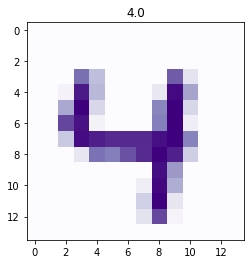

In [10]:
reshapeSize = int(np.sqrt(len(testDataMN[0][:]))) 
#Choose a random image to show:
n = random.sample(range(0, len(testDataMN[0][:])), 1) 

#Showing the image with it's assigend label:
plt.imshow(testDataMN[n][:].reshape(reshapeSize, reshapeSize), cmap=plt.cm.Purples)
plt.title(testLabelsMN[n][0][0])
plt.show()

Employing My Implemetation of Gaussian Naive Bayes Classifier

In [11]:
myClsfGNB = myGNB(1e-01)
myClsfGNB.fit(trainDataMN, trainLabelsMN.ravel())
predLabelsGNB = myClsfGNB.predict(testDataMN)
print('The accuracy of employing my implementation of Gaussian Naive Bayes' 
      ' classifier is: %1.2f %%' %((predLabelsGNB==testLabelsMN.ravel()).mean()*100))

#Calculating Confusion Matrix:
myConfMat = calcConfMat(testLabelsMN.ravel(), predLabelsGNB)
#F1 Score of Classes:
calcF1Score(myConfMat)

The classifier is created successfully!
*
*
*
*
*
The accuracy of employing my implementation of Gaussian Naive Bayes classifier is: 70.56 %
╒══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤═══════════╕
│          │  class1  │  class2  │  class3  │  class4  │  class5  │  class6  │  class7  │  class8  │  class9  │  class10  │
╞══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪═══════════╡
│ F1 Score │  0.8665  │  0.6619  │  0.649   │  0.7203  │  0.7555  │  0.5738  │  0.7783  │  0.7812  │   0.56   │   0.698   │
╘══════════╧══════════╧══════════╧══════════╧══════════╧══════════╧══════════╧══════════╧══════════╧══════════╧═══════════╛


Employing My Implemetation of Gaussian Optimal Bayes Classifier

In [12]:
myClsfGOptB = myGOptB(1e-01, "Unity Matrix")
myClsfGOptB.fit(trainDataMN, trainLabelsMN.ravel())
predLabelsGOptB = myClsfGOptB.predict(testDataMN)
print('The accuracy of employing my implementation of Gaussian Optimal Bayes' 
      ' classifier (using unity matrix) is: %1.2f %%' 
      %((predLabelsGOptB==testLabelsMN.ravel()).mean()*100))

#Calculating Confusion Matrix:
myConfMat = calcConfMat(testLabelsMN.ravel(), predLabelsGOptB)
#F1 Score of Classes:
calcF1Score(myConfMat)

myClsfGOptB = myGOptB(method="Eigen Values")
myClsfGOptB.fit(trainDataMN, trainLabelsMN.ravel())
predLabelsGOptB = myClsfGOptB.predict(testDataMN)
print('The accuracy of employing my implementation of Gaussian Optimal Bayes' 
      'classifier (using eigen values) is: %1.2f %%' 
      %((predLabelsGOptB==testLabelsMN.ravel()).mean()*100))

#Calculating Confusion Matrix:
myConfMat = calcConfMat(testLabelsMN.ravel(), predLabelsGOptB)
#F1 Score of Classes:
calcF1Score(myConfMat)

The classifier is created successfully!
*
*
*
*
*
The accuracy of employing my implementation of Gaussian Optimal Bayes classifier (using unity matrix) is: 82.60 %
╒══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤═══════════╕
│          │  class1  │  class2  │  class3  │  class4  │  class5  │  class6  │  class7  │  class8  │  class9  │  class10  │
╞══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪═══════════╡
│ F1 Score │  0.8607  │  0.894   │  0.8489  │  0.8021  │  0.8545  │  0.7052  │  0.8792  │  0.8889  │  0.6624  │  0.8816   │
╘══════════╧══════════╧══════════╧══════════╧══════════╧══════════╧══════════╧══════════╧══════════╧══════════╧═══════════╛
The classifier is created successfully!
*
*
*
*
*
The accuracy of employing my implementation of Gaussian Optimal Bayesclassifier (using eigen values) is: 79.84 %
╒══════════╤══════════╤══════════╤══════════╤════════

Part C

Read Noisy Moons

In [13]:
noisyMoons = pd.read_csv(r'/content/gdrive/My Drive/Colab Notebooks/HW/2/Noisy Moons.csv', header=None)

Represing 5 Rows of It:

In [14]:
noisyMoons.head(n=5)

,0,1,2
0,0.356071,0.900969,0.0
1,-0.211718,0.470320,1.0
2,0.143059,0.105296,1.0
3,1.742551,-0.119097,1.0
4,1.931149,-0.266267,1.0


Plotting Data Based on Its Classes

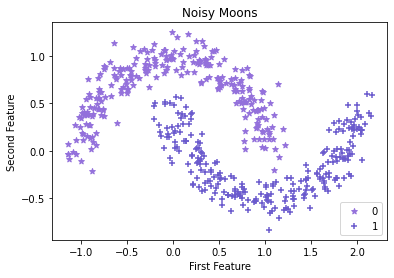

In [15]:
noisyMoons = noisyMoons.values
zerosData = np.array([noisyMoons[i,0:2] for i in range(len(noisyMoons)) if noisyMoons[i,2]==0])
onesData = np.array([noisyMoons[i,0:2] for i in range(len(noisyMoons)) if noisyMoons[i,2]==1])


plt.scatter(zerosData[:,0], zerosData[:,1],
                marker='*', color='mediumpurple', label=0)
plt.scatter(onesData[:,0], onesData[:,1],
                marker='+', color='slateblue', label=1)

plt.title('Noisy Moons')
plt.xlabel('First Feature')
plt.ylabel('Second Feature')
plt.legend(loc="lower right")
plt.show()

Splitting Data

In [16]:
def splitData(X, y, totalSize, testSize):
  indexes = random.sample(range(0, totalSize), testSize)
  indexes.sort()

  testData = X[indexes]
  testLabel = y[indexes]

  XList = X.tolist()
  for i in range(testSize):
    XList.pop(indexes[i]-i)
  trainData = np.array(XList)

  y = np.delete(y, indexes)
  trainLabel = y

  return trainData, trainLabel, testData, testLabel

Splitting Noisy Moon Data

In [17]:
#Extracting Features:
X = noisyMoons[:,0:2]

#Extracting Labels(Classes):
y = noisyMoons[:,2]

#Splitting Data:
trainData, trainLabels, testData, testLabels = splitData(X, y, len(X), int(0.2*len(X)))

Calulate F1 Scores:

In [18]:
def calcF1ScoreMoon(matrix):
  f1Scores = 2 * calcPrecisionConfMat(matrix) * calcRecallConfMat(matrix)/(calcPrecisionConfMat(matrix)+calcRecallConfMat(matrix))
  plotTable({1:["F1 Score"], 
                2:['{:1.4f}'.format(f1Scores[0])],
                3:['{:1.4f}'.format(f1Scores[1])]},
                ['class'+str(i) for i in range(1,3)], 3) 

Employing My Implemetation of Gaussian Naive Bayes Classifier

In [19]:
myClsfGNB = myGNB(1e-07)
myClsfGNB.fit(trainData, trainLabels)
predLabelsGNB = myClsfGNB.predict(testData)
print('The accuracy of employing my implementation of Gaussian Naive Bayes'
      ' classifier is: %1.2f %%' %((predLabelsGNB==testLabels).mean()*100))

#Calculating Confusion Matrix:
myConfMat = calcConfMat(testLabels, predLabelsGNB)
#F1 Score of Classes:
calcF1ScoreMoon(myConfMat)

The classifier is created successfully!
*
*
*
*
*
The accuracy of employing my implementation of Gaussian Naive Bayes classifier is: 87.00 %
╒══════════╤══════════╤══════════╕
│          │  class1  │  class2  │
╞══════════╪══════════╪══════════╡
│ F1 Score │  0.8687  │  0.8713  │
╘══════════╧══════════╧══════════╛


Employing My Implemetation of Gaussian Optimal Bayes Classifier

In [20]:
myClsfGOptB = myGOptB(1e-01, "Unity Matrix")
myClsfGOptB.fit(trainData, trainLabels)
predLabelsGOptB = myClsfGOptB.predict(testData)
print('The accuracy of employing my implementation of Gaussian Optimal Bayes' 
      ' classifier (using unity matrix) is: %1.2f %%' 
      %((predLabelsGOptB==testLabels).mean()*100))

#Calculating Confusion Matrix:
myConfMat = calcConfMat(testLabels, predLabelsGOptB)
#F1 Score of Classes:
calcF1ScoreMoon(myConfMat)

myClsfGOptB = myGOptB(method="Eigen Values")
myClsfGOptB.fit(trainData, trainLabels)
predLabelsGOptB = myClsfGOptB.predict(testData)
print('The accuracy of employing my implementation of Gaussian Optimal Bayes' 
      ' classifier (using eigen values) is: %1.2f %%' 
      %((predLabelsGOptB==testLabels).mean()*100))


#Calculating Confusion Matrix:
myConfMat = calcConfMat(testLabels, predLabelsGOptB)
#F1 Score of Classes:
calcF1ScoreMoon(myConfMat)

The classifier is created successfully!
*
*
*
*
*
The accuracy of employing my implementation of Gaussian Optimal Bayes classifier (using unity matrix) is: 88.00 %
╒══════════╤══════════╤══════════╕
│          │  class1  │  class2  │
╞══════════╪══════════╪══════════╡
│ F1 Score │  0.8776  │  0.8824  │
╘══════════╧══════════╧══════════╛
The classifier is created successfully!
*
*
*
*
*
The accuracy of employing my implementation of Gaussian Optimal Bayes classifier (using eigen values) is: 88.00 %
╒══════════╤══════════╤══════════╕
│          │  class1  │  class2  │
╞══════════╪══════════╪══════════╡
│ F1 Score │  0.8776  │  0.8824  │
╘══════════╧══════════╧══════════╛


Part D:

Tiny MNIST

Calculate F1 Score with SKLearn

In [21]:
def calcf1ScoreSK(testLabels, predLabels):
  f1Scores = f1Score(testLabels, predLabels, average=None)
  plotTable({1:["F1 Score"], 
                2:['{:1.4f}'.format(f1Scores[0])],
                3:['{:1.4f}'.format(f1Scores[1])],
                4:['{:1.4f}'.format(f1Scores[2])],
                5:['{:1.4f}'.format(f1Scores[3])],
                6:['{:1.4f}'.format(f1Scores[4])],
                7:['{:1.4f}'.format(f1Scores[5])],
                8:['{:1.4f}'.format(f1Scores[6])],
                9:['{:1.4f}'.format(f1Scores[7])],
                10:['{:1.4f}'.format(f1Scores[8])],
                11:['{:1.4f}'.format(f1Scores[9])],},
                ['class'+str(i) for i in range(1,11)], 11) 

In [22]:
_priors = [np.mean(trainLabelsMN==label) for label in [0,1,2,3,4,5,6,7,8,9]]
skClsf = GaussianNB(priors=_priors, var_smoothing=1e-01)
# skClsf = GaussianNB(var_smoothing=1e-01)
skClsf.fit(trainDataMN, trainLabelsMN.ravel())
predLabelsSK = skClsf.predict(testDataMN)
print("The accuracy of employing sklearn's implementation of Gaussian Naive Bayes classifier is: %1.2f %%" %((predLabelsSK==testLabelsMN.ravel()).mean()*100))

#F1 Score of Classes:
calcf1ScoreSK(testLabelsMN.ravel(), predLabelsSK)

The accuracy of employing sklearn's implementation of Gaussian Naive Bayes classifier is: 75.44 %
╒══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤═══════════╕
│          │  class1  │  class2  │  class3  │  class4  │  class5  │  class6  │  class7  │  class8  │  class9  │  class10  │
╞══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪═══════════╡
│ F1 Score │  0.8688  │  0.8099  │  0.786   │  0.7713  │  0.7366  │  0.6103  │  0.816   │  0.7992  │  0.6213  │  0.6924   │
╘══════════╧══════════╧══════════╧══════════╧══════════╧══════════╧══════════╧══════════╧══════════╧══════════╧═══════════╛


Noisy Moon

Calculate F1 Score with SKLearn

In [23]:
def calcf1ScoreSKMoon(testLabels, predLabels):
  f1Scores = f1Score(testLabels, predLabels, average=None)
  plotTable({1:["F1 Score"], 
                2:['{:1.4f}'.format(f1Scores[0])],
                3:['{:1.4f}'.format(f1Scores[1])]},
                ['class'+str(i) for i in range(1,3)], 3) 

In [24]:
skClsf = GaussianNB(var_smoothing=1e-07)
skClsf.fit(trainData, trainLabels)
predLabelsSK = skClsf.predict(testData)
print("The accuracy of employing sklearn's implementation of Gaussian Naive Bayes classifier is: %1.2f %%" %((predLabelsSK==testLabels).mean()*100))
#F1 Score of Classes:
calcf1ScoreSKMoon(testLabels, predLabelsSK)

The accuracy of employing sklearn's implementation of Gaussian Naive Bayes classifier is: 87.00 %
╒══════════╤══════════╤══════════╕
│          │  class1  │  class2  │
╞══════════╪══════════╪══════════╡
│ F1 Score │  0.8687  │  0.8713  │
╘══════════╧══════════╧══════════╛
